# TSP using a heuristic solver

This notebook shows how to use hill climbing to solve TSP. We should note that are better approximate and heuristic algorithms for TSP in the research literature.

In [3]:
!pip install python_tsp

In [4]:
import numpy as np
import math
from python_tsp.exact import solve_tsp_dynamic_programming
from itertools import permutations
import copy


In [5]:
distance_matrix = np.array([
    [0,  5, 4, 10, 6, 9 ],
    [5,  0, 8,  5, 3, 11],
    [4,  8, 0,  3, 2, 4 ],
    [10, 5, 3,  0, 8, 7 ],
    [6,  3, 2,  8, 0, 8 ],
    [9, 11, 4,  7, 8, 0 ]
])


In [6]:
def n_cities(distance_matrix):
    " number of cities in a distance_matrix"
    assert distance_matrix.shape[0] == distance_matrix.shape[1]
    return distance_matrix.shape[0]

In [7]:
n_cities(distance_matrix)

6

In [8]:
def cities(distance_matrix):
    " list with city numbers in a tsp distance_matrix"
    return list(range(0,n_cities(distance_matrix)))

In [9]:
cities(distance_matrix)

[0, 1, 2, 3, 4, 5]

In [10]:
def cost_function(path, distance_matrix):
    "cost function for a TSP problem instance given as a distrance matrix"
    cost=0
    for i in range(len(path)-1):
        cost = cost + distance_matrix[path[i],path[i+1]]
    cost = cost + distance_matrix[path[-1],path[0]]
    return cost

In [11]:
def solve_tsp_brute_force(distance_matrix):
    "a brute force implementation of TSP"
    steps=0
    best_path = None
    for alternative in permutations(cities(distance_matrix)):
        steps = steps +1
        if best_path is None or cost_function(best_path, distance_matrix ) > cost_function(alternative, distance_matrix):
            best_path = list(alternative)
    return best_path, cost_function(best_path, distance_matrix), steps


In [12]:
def cycle(path):
    "make a cyclic path"
    return path+path[0:1]

In [13]:
path, distance,steps = solve_tsp_brute_force(distance_matrix)
print(cycle(path), distance)
print("Steps", steps, " (n!)")

[0, 1, 3, 5, 2, 4, 0] 29
Steps 720  (n!)


In [14]:
# Use the dynamic programming solver provided by python-tsp
path, distance = solve_tsp_dynamic_programming(distance_matrix)
print(cycle(path), distance)
n=n_cities(distance_matrix)
print("Steps", n**2*2**n , " (n^2*2^n)")

[0, 1, 3, 5, 2, 4, 0] 29
Steps 2304  (n^2*2^n)


In [15]:
def tsp_random(distance_matrix, budget):
    "global random search for TSP"
    best_path=None

    for trials in range(budget):

        # move: global random search
        alternative=list(np.random.permutation(cities(distance_matrix)))

        if best_path is None or cost_function(best_path, distance_matrix ) > cost_function(alternative, distance_matrix):
            best_path = alternative

    return best_path, cost_function(best_path, distance_matrix)

In [16]:
tsp_random(distance_matrix, 100)

([4, 0, 1, 3, 5, 2], 29)

In [17]:
def tsp_hilldescent(distance_matrix, budget):
    "local hill descent for TSP"

    # initial solution
    best_path=list(np.random.permutation(cities(distance_matrix)))

    for trials in range(budget):

        if np.random.random()<0.9:
            # move: local search
            alternative = select_neighbourgh(best_path)
        else:
            # move: global random search
            alternative=list(np.random.permutation(cities(distance_matrix)))

        if cost_function(best_path, distance_matrix ) > cost_function(alternative, distance_matrix):
            best_path = alternative

    return best_path, cost_function(best_path, distance_matrix)

In [18]:
def select_neighbourgh(path):
    "return a new path where two cities are swapped randomly."

    i = np.random.randint(0,len(path))
    j=i
    while j==i:
        j = np.random.randint(0,len(path))
    path = copy.copy(path)
    path[i],path[j] = path[j], path[i]

    return path

In [19]:
tsp_hilldescent(distance_matrix,25)

([0, 1, 4, 2, 3, 5], 29)

In [20]:
from python_tsp.distances import euclidean_distance_matrix

In [21]:
import matplotlib.pyplot as plt

def plotTSP(paths, points, num_iters=1, budget=None, cost=None):
    """
    Show a TSP problem instance and its solution

    paths: List of lists with the different orders in which the nodes are visited
    points: coordinates for the different nodes
    num_iters: number of paths that are in the path list

    source: https://gist.github.com/payoung/6087046
    """

    # Unpack the primary TSP path and transform it into a list of ordered
    # coordinates

    x = []; y = []
    for i in paths[0]:
        x.append(points[i][0])
        y.append(points[i][1])

    plt.plot(x, y, 'co')

    # Set a scale for the arrow heads (there should be a reasonable default for this, WTF?)
    a_scale = float(max(x))/float(100)

    # Draw the older paths, if provided
    if num_iters > 1:

        for i in range(1, num_iters):

            # Transform the old paths into a list of coordinates
            xi = []; yi = [];
            for j in paths[i]:
                xi.append(points[j][0])
                yi.append(points[j][1])

            plt.arrow(xi[-1], yi[-1], (xi[0] - xi[-1]), (yi[0] - yi[-1]),
                    head_width = a_scale, color = 'r',
                    length_includes_head = True, ls = 'dashed',
                    width = 0.001/float(num_iters))
            for i in range(0, len(x) - 1):
                plt.arrow(xi[i], yi[i], (xi[i+1] - xi[i]), (yi[i+1] - yi[i]),
                        head_width = a_scale, color = 'r', length_includes_head = True,
                        ls = 'dashed', width = 0.001/float(num_iters))

    # Draw the primary path for the TSP problem
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale,
            color ='g', length_includes_head=True)
    for i in range(0,len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                color = 'g', length_includes_head = True)

    #Set axis too slitghtly larger than the set of x and y
    plt.xlim(0, max(x)*1.1)
    plt.ylim(0, max(y)*1.1)
    if budget and cost:
        plt.title("TSP budget %d best solution cost %.2f" % (budget, cost))
    elif cost:
        plt.title("TSP best solution cost %.2f" % (cost))
    plt.show()

In [22]:
N=16 # number of cities
city_locations = np.random.uniform(0,100, (N,2)) # x,y coordinates each city

In [23]:
city_locations

array([[66.2865335 , 83.04605673],
       [61.72078503, 14.21537886],
       [14.9866077 , 23.40409103],
       [55.05496964, 75.36324899],
       [98.78520588, 14.2276963 ],
       [ 7.28653035,  8.08072825],
       [78.77838058, 65.70486134],
       [97.86575195, 25.70773236],
       [52.92609635, 25.34852949],
       [90.03360133, 28.11908991],
       [32.02890123, 81.96901488],
       [ 3.74492609, 52.65620608],
       [27.57092142, 99.46940785],
       [64.17522983, 95.95265175],
       [44.69102961, 80.74318411],
       [80.76089729, 80.77596912]])

In [24]:
print("Steps brute force", math.factorial(N))
print("Steps dynamic programming",  N**2 * 2**N )

Steps brute force 20922789888000
Steps dynamic programming 16777216


In [25]:
def run_tsp(algorithm, city_locations, budget =None, plot= True):
    distance_matrix = euclidean_distance_matrix(city_locations)
    if budget:
        path, _ = algorithm(distance_matrix,budget)
    else:
        path, _ = algorithm(distance_matrix)
    cost = cost_function(path, distance_matrix)
    if plot:
        plotTSP([path],city_locations,budget=budget,cost=cost)
    return path, cost

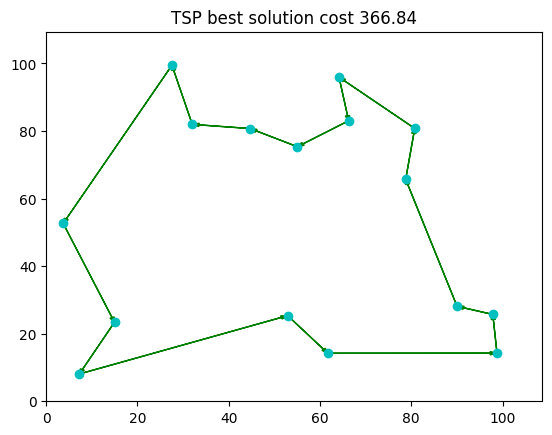

([0, 3, 14, 10, 12, 11, 2, 5, 8, 1, 4, 7, 9, 6, 15, 13], 366.836639335628)

In [26]:
run_tsp(solve_tsp_dynamic_programming, city_locations)

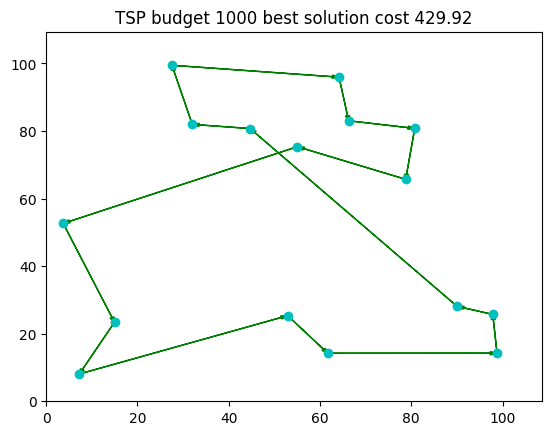

([1, 4, 7, 9, 14, 10, 12, 13, 0, 15, 6, 3, 11, 2, 5, 8], 429.92002454882504)

In [27]:
run_tsp(tsp_hilldescent, city_locations, budget= 1000)

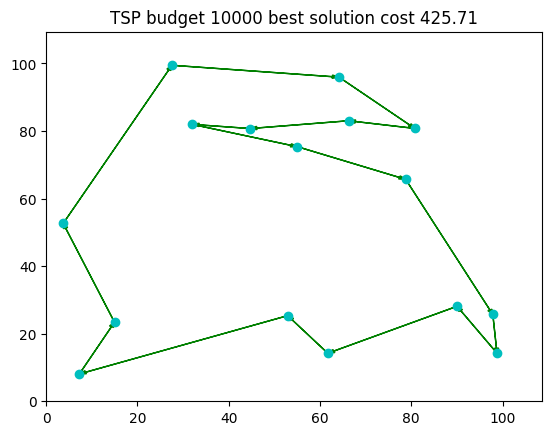

([11, 12, 13, 15, 0, 14, 10, 3, 6, 7, 4, 9, 1, 8, 5, 2], 425.7092184246801)

In [28]:
run_tsp(tsp_hilldescent, city_locations, budget= 10000)

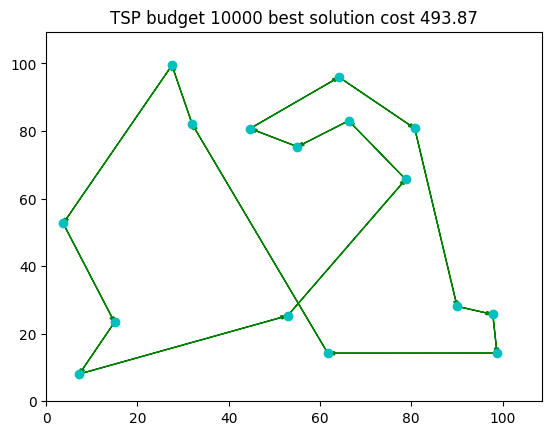

([0, 3, 14, 13, 15, 9, 7, 4, 1, 10, 12, 11, 2, 5, 8, 6], 493.871209139264)

In [29]:
run_tsp(tsp_hilldescent,city_locations,budget= 10000)

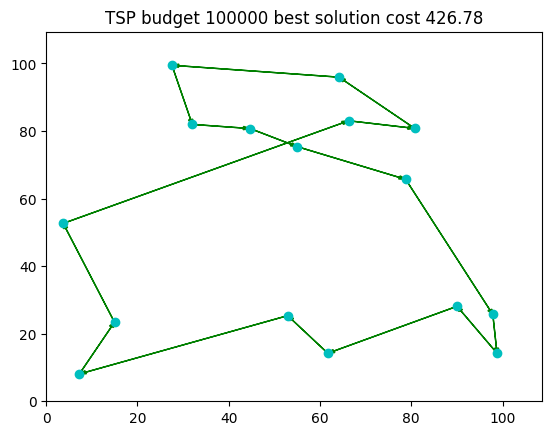

([14, 3, 6, 7, 4, 9, 1, 8, 5, 2, 11, 0, 15, 13, 12, 10], 426.77927219126644)

In [30]:
run_tsp(tsp_hilldescent, city_locations, budget= 100000)

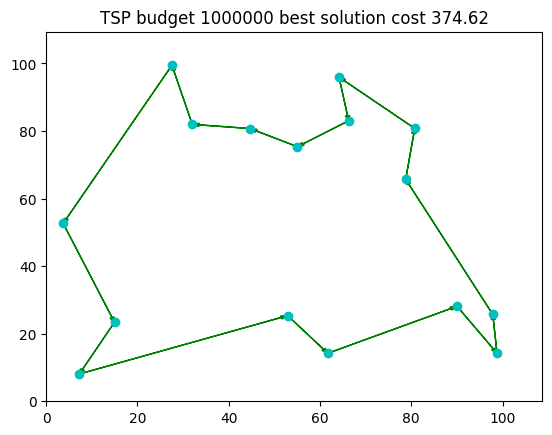

([10, 12, 11, 2, 5, 8, 1, 9, 4, 7, 6, 15, 13, 0, 3, 14], 374.6214187114078)

In [31]:
run_tsp(tsp_hilldescent, city_locations, budget= 1000000)

# Comparing Algorithms

Experimental parameters

In [99]:
np.random.seed(1)

N=20 # number of cities
city_locations = np.random.uniform(0,100, (N,2)) # x,y coordinates each city

N_RUNS = 30
BUDGET = 1000

## TSP using Hill Descent

In [100]:
results_hilldescent=[]
for i in range(1,1+N_RUNS):
    path, cost = run_tsp(tsp_hilldescent,city_locations,budget= BUDGET, plot=False)
    results_hilldescent.append(cost)
    print("Run %d, best cost %.2f" % (i, cost))

Run 1, best cost 438.27
Run 2, best cost 453.22
Run 3, best cost 549.72
Run 4, best cost 451.90
Run 5, best cost 449.21
Run 6, best cost 466.76
Run 7, best cost 451.98
Run 8, best cost 438.02
Run 9, best cost 509.84
Run 10, best cost 425.95
Run 11, best cost 381.02
Run 12, best cost 461.81
Run 13, best cost 410.93
Run 14, best cost 485.73
Run 15, best cost 449.94
Run 16, best cost 493.11
Run 17, best cost 385.64
Run 18, best cost 495.70
Run 19, best cost 450.62
Run 20, best cost 445.06
Run 21, best cost 497.48
Run 22, best cost 436.99
Run 23, best cost 423.68
Run 24, best cost 498.94
Run 25, best cost 434.37
Run 26, best cost 439.61
Run 27, best cost 527.73
Run 28, best cost 542.98
Run 29, best cost 505.64
Run 30, best cost 479.78


Mean

In [101]:
np.mean(results_hilldescent)

462.72148817477716

In [102]:
np.median(results_hilldescent)

451.9368629832436

Standard deviation

In [103]:
np.std(results_hilldescent)

40.89742209813542

Histogram

(array([2., 1., 2., 6., 7., 2., 5., 2., 1., 2.]),
 array([381.02402741, 397.89408924, 414.76415106, 431.63421289,
        448.50427472, 465.37433655, 482.24439838, 499.11446021,
        515.98452203, 532.85458386, 549.72464569]),
 <BarContainer object of 10 artists>)

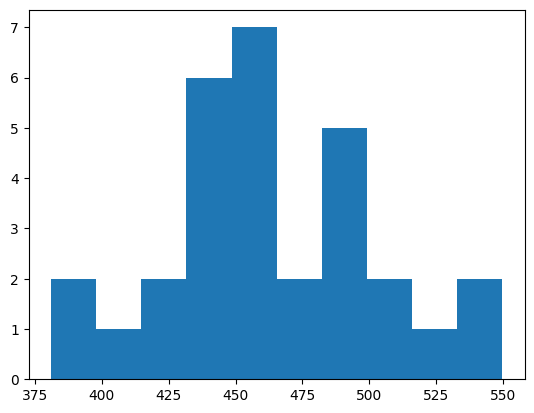

In [104]:
plt.hist(results_hilldescent)

Boxplot

{'whiskers': [<matplotlib.lines.Line2D at 0x7efd3ff852a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7efd40727040>,
 'boxes': [<matplotlib.lines.Line2D at 0x7efd3ff59630>],
 'medians': [<matplotlib.lines.Line2D at 0x7efd407249d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7efd40724790>],
 'means': []}

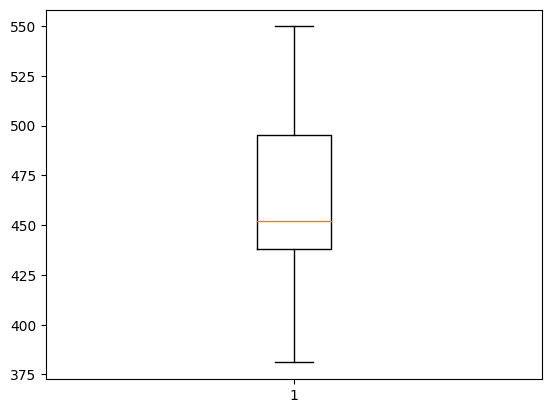

In [105]:
plt.boxplot(results_hilldescent)

## TSP using Random Search

In [106]:
results_random=[]
for i in range(1,1+N_RUNS):
    path, cost = run_tsp(tsp_random,city_locations,budget= BUDGET, plot=False)
    results_random.append(cost)
    print("Run %d, best cost %.2f" % (i, cost))

Run 1, best cost 686.92
Run 2, best cost 739.38
Run 3, best cost 651.79
Run 4, best cost 734.41
Run 5, best cost 755.48
Run 6, best cost 781.69
Run 7, best cost 694.02
Run 8, best cost 767.00
Run 9, best cost 698.54
Run 10, best cost 754.80
Run 11, best cost 695.18
Run 12, best cost 707.40
Run 13, best cost 745.84
Run 14, best cost 728.57
Run 15, best cost 592.71
Run 16, best cost 710.86
Run 17, best cost 780.23
Run 18, best cost 730.43
Run 19, best cost 733.99
Run 20, best cost 740.70
Run 21, best cost 730.62
Run 22, best cost 701.95
Run 23, best cost 739.77
Run 24, best cost 746.57
Run 25, best cost 690.40
Run 26, best cost 734.95
Run 27, best cost 721.39
Run 28, best cost 723.96
Run 29, best cost 740.10
Run 30, best cost 747.49


(array([ 1.,  0.,  0.,  1.,  1.,  5.,  4., 10.,  5.,  3.]),
 array([592.70798947, 611.60622282, 630.50445616, 649.4026895 ,
        668.30092285, 687.19915619, 706.09738953, 724.99562288,
        743.89385622, 762.79208956, 781.69032291]),
 <BarContainer object of 10 artists>)

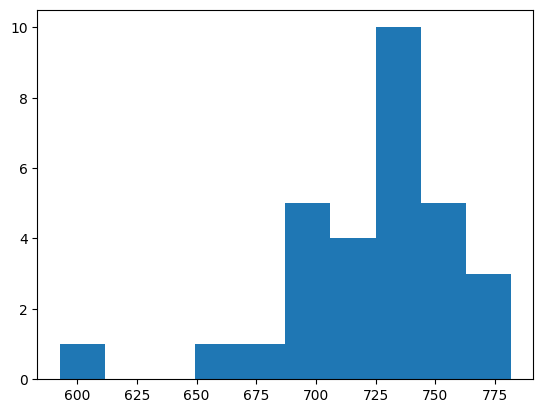

In [107]:
plt.hist(results_random)

Boxplot for two data series

{'whiskers': [<matplotlib.lines.Line2D at 0x7efd4096b0d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7efd4096b520>,
 'boxes': [<matplotlib.lines.Line2D at 0x7efd4096af20>,
 'medians': [<matplotlib.lines.Line2D at 0x7efd4096baf0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efd4096bdf0>,
 'means': []}

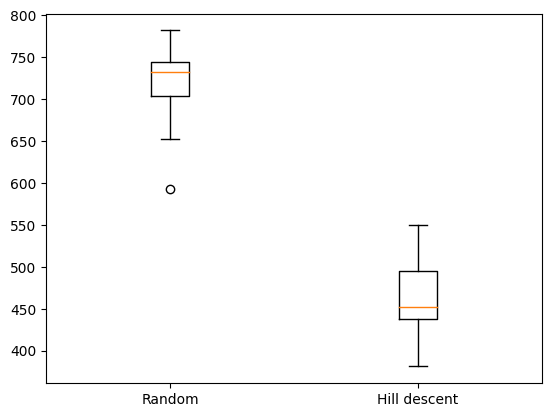

In [108]:
plt.boxplot([results_random, results_hilldescent],labels=["Random","Hill descent"])

## Statistical Test

In [109]:
import scipy
U, p = scipy.stats.mannwhitneyu(results_random, results_hilldescent, alternative="two-sided")

In [110]:
p

3.019859359162157e-11

In [111]:
if p < 0.05: 
    print("Observed differences are statistically significant (p = %.2f)" % p)
else:
    print("Observed differences are not statistically significant (p = %.2f)" % p)
print("Two-sided Mann-Whitney U test, significance level 5%.")

Observed differences are statistically significant (p = 0.00)
Two-sided Mann-Whitney U test, significance level 5%.
